In [15]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion
from tensorflow.keras import layers, models

import os
from PIL import Image


2024-09-10 16:49:08.254086: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-10 16:49:08.328832: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-10 16:49:08.402769: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-10 16:49:08.473640: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-10 16:49:08.493409: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-10 16:49:08.603467: I tensorflow/core/platform/cpu_feature_gu

In [4]:
TRAIN_DIR = '/home/kikosolovic/Desktop/DogCatModel/dogs-vs-cats-redux-kernels-edition/train'
TEST_DIR = '/home/kikosolovic/Desktop/DogCatModel/dogs-vs-cats-redux-kernels-edition/test'
IMG_SIZE = 50
LR = 1e-3

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic') # just so we remember which saved model is which, sizes must match

In [5]:
def label_img(img):
    word_label = img.split('.')[-3]
    # conversion to one-hot array [cat,dog]
    #                            [much cat, no dog]
    if word_label == 'cat': return [1,0]
    #                             [no cat, very doggo]
    elif word_label == 'dog': return [0,1]

In [6]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    # np.save('train_data.npy', training_data)
    return training_data

In [7]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    # np.save('test_data.npy', testing_data)
    return testing_data

In [8]:
train_data = create_train_data()

 35%|███▌      | 8870/25000 [00:05<00:10, 1554.65it/s]


KeyboardInterrupt: 

In [9]:
def load_images(directory, label, cat):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if (filename.endswith(".jpg") or filename.endswith(".png") and ((filename.split("."[0]) == "cat") == cat )):
            img = Image.open(os.path.join(directory, filename))
            img = img.resize((50, 50))  # Resize images to a consistent size
            img_array = np.array(img) / 255.0  # Normalize pixel values
            images.append(img_array)
            labels.append(label)
    return np.array(images), np.array(labels)


In [10]:
# Load dog images
dog_images, dog_labels = load_images(TRAIN_DIR, 1, False)

# Load cat images
cat_images, cat_labels = load_images(TRAIN_DIR, 0, True)


In [11]:
X = np.concatenate((dog_images, cat_images), axis=0)
y = np.concatenate((dog_labels, cat_labels), axis=0)


In [12]:
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]


In [13]:
# Split into train and test sets
split = int(0.8 * X.shape[0])
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [22]:
def getme():
    img = Image.open("/home/kikosolovic/Downloads/image2.jpg")
    img = img.resize((50, 50))  # Resize images to a consistent size
    img_array = np.array(img) / 255.0  # Normalize pixel values
    return img_array


In [23]:
img =getme()


In [24]:
input_data = np.expand_dims(img, axis=0)

In [42]:
prediction = model.predict(input_data)
Dog = prediction[0][0]
Prediction = 0.89483975

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [16]:
# Create the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=5,
    validation_split=0.2
)

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f'\nTest accuracy: {test_acc}')

# Save the model
model.save('dog_cat_classifier.h5')

/home/kikosolovic/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1725979756.483536  112176 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-09-10 16:49:16.487568: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries

Epoch 1/15


2024-09-10 16:49:16.986695: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 960000000 exceeds 10% of free system memory.


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 33s 32ms/step - accuracy: 0.5022 - loss: 0.6938 - val_accuracy: 0.5019 - val_loss: 0.6932
Epoch 2/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.4942 - loss: 0.6932 - val_accuracy: 0.5019 - val_loss: 0.6932
Epoch 3/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 33ms/step - accuracy: 0.5024 - loss: 0.6932 - val_accuracy: 0.5019 - val_loss: 0.6931
Epoch 4/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 39s 39ms/step - accuracy: 0.4900 - loss: 0.6932 - val_accuracy: 0.4981 - val_loss: 0.6931
Epoch 5/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.5004 - loss: 0.6932 - val_accuracy: 0.5019 - val_loss: 0.6931
Epoch 6/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.5005 - loss: 0.6932 - val_accuracy: 0.5019 - val_loss: 0.6931
Epoch 7/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 33s 33ms/step - accuracy: 0.5014 - loss: 0.6932 - val_accuracy: 0.5019 - val_loss: 0.6931
Epoch 8/15
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 34s 34ms/step - accuracy: 0.4979 - loss: 0.69


Test accuracy: 0.4952999949455261


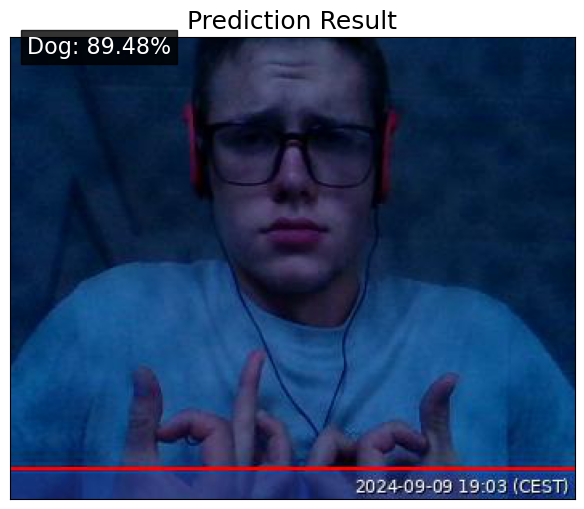

In [43]:
import matplotlib.pyplot as plt
img = Image.open("/home/kikosolovic/Downloads/image2.jpg")

fig, ax = plt.subplots(figsize=(8, 6))

ax.imshow(img)
ax.set_xticks([])
ax.set_yticks([])

label = "Dog" if Prediction > 0.5 else "Cat"

text = f"{label}: {Prediction:.2%}"
ax.text(10, 10, text, color='white', fontsize=16, bbox=dict(facecolor='black', alpha=0.8))

plt.title("Prediction Result", fontsize=18)
plt.show()

